## Libraries

In [21]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

## Data

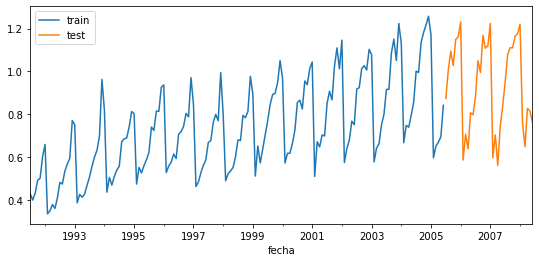

In [22]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Train forecaster

In [23]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = GradientBoostingRegressor(),
                    steps     = 36,
                    lags      = 15
                )

forecaster.fit(y=data_train)
forecaster

============================ForecasterAutoregMultiOutput============================
Regressor: GradientBoostingRegressor()
Steps: 36
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

## Prediction

In [24]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(3)

fecha
2005-07-01    0.877073
2005-08-01    0.974353
2005-09-01    1.021718
Freq: MS, dtype: float64

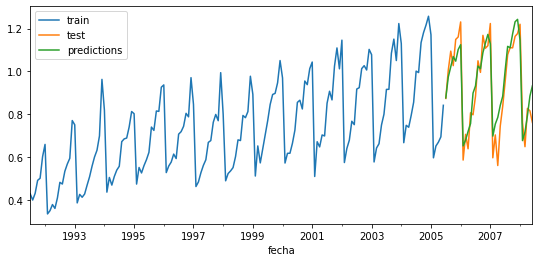

In [25]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [26]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.006208145903529839


## Feature importance

Since `ForecasterAutoregMultiOutput` fits one model per step,it is necessary to specify from which model retrieve its feature importance.

In [27]:
# When using as regressor LinearRegression, Ridge or Lasso
# forecaster.get_coef()

# When using as regressor RandomForestRegressor or GradientBoostingRegressor
forecaster.get_feature_importances(step=1)

array([0.0070333 , 0.07330653, 0.03192484, 0.00284055, 0.00525716,
       0.0039042 , 0.00717631, 0.00676659, 0.00587334, 0.00856639,
       0.01275252, 0.81823596, 0.005138  , 0.00413031, 0.007094  ])

## Extract training matrix

Two steps are needed. One to create the whole training matrix and a second one to subset the data needed for each model (step).

In [28]:
X, y = forecaster.create_train_X_y(data_train)
# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
                step    = 1,
                X_train = X,
                y_train = y,
            )